In [83]:
# Standard Python libraries
import os
import time
import warnings
from IPython.display import clear_output

# Data manipulation and numerical libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Scikit-learn
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, classification_report

# Qiskit Core
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap, ZFeatureMap
from qiskit.primitives import Sampler

# Qiskit Algorithms
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals

# Qiskit Machine Learning
from qiskit_machine_learning.algorithms.classifiers import (
    NeuralNetworkClassifier,
    VQC
)
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import PegasosQSVC
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
# Qiskit Runtime
from qiskit_ibm_runtime import Session, QiskitRuntimeService
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

In [84]:
def setup_environment():
    """Set up the environment with necessary configurations."""
    warnings.filterwarnings("ignore")
    pd.set_option("display.max_rows", None)
    plt.style.use('ggplot')
    algorithm_globals.random_seed = 12345

In [85]:
# **Important:** Modify these constants to configure the script for your specific dataset and experiment.

DATASET_PATH = "datasets/heart.csv"  # Path to your CSV dataset file
TARGET_COLUMN = "HeartDisease"  # Name of the column you want to predict
FEATURE_COUNTS = [2,3,4,5,6,7,8,9,10,11]  # List of feature counts to evaluate
CROSS_VALIDATION_FOLDS = 2  # Number of cross-validation folds
HANDLE_IMBALANCE = 'smote'  # Method to handle class imbalance: 'smote', 'undersample', or None
IMBALANCE_THRESHOLD = 0.7  # Ratio of majority/minority class to trigger imbalance handling
USE_REAL_QUANTUM = True  # Set to True to use a real quantum computer (requires Qiskit Runtime setup)
OUTPUT_FILE = "results.csv"  # Output file to save the results
VERBOSE = True  # Set to True for more detailed output during execution

In [86]:
def load_and_preprocess_data(dataset_path, target_column, imbalance_threshold=0.7, verbose=False):
    """Loads, preprocesses, and splits the data, handling class imbalance.

    Args:
        dataset_path (str): Path to the CSV dataset.
        target_column (str): Name of the target column.
        imbalance_threshold (float): Ratio of majority to minority class to trigger imbalance handling.
        verbose (bool): Print additional debugging information.

    Returns:
        tuple: (X, y, feature_names) - features, target, and original feature names.
        Or None if significant imbalance is detected and no handling method is specified.
    """
    try:
        df = pd.read_csv(dataset_path)
    except FileNotFoundError:
        raise FileNotFoundError(f"Dataset not found at {dataset_path}")

    if target_column not in df.columns:
        raise ValueError(f"Target column '{target_column}' not found in dataset.")

    # --- Handle Missing Values (Flexible Approach) ---
    for col in df.columns:
        if df[col].isnull().any():
            if verbose:
                print(f"Column '{col}' has missing values.")
            if df.shape[0] > 10000:
                # Drop rows with missing values if dataset is large
                df.dropna(inplace=True)
            elif df[col].dtype == 'object' or df[col].dtype == 'string':
                # Fill categorical with most frequent
                df[col] = df[col].fillna(df[col].mode()[0])
            else:
                # Fill numerical with median
                df[col] = df[col].fillna(df[col].median())
    print(f"Dataset's shape is: {df.shape}")

    # --- Identify and Encode Categorical Columns ---
    categorical_cols = []
    for col in df.columns:
        if df[col].dtype == 'object' or df[col].dtype == 'string':
            categorical_cols.append(col)
            if verbose:
                print(f"Treating column '{col}' as categorical.")
            # Ensure type consistency before encoding
            df[col] = df[col].astype(str)
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])

    feature_names = df.drop(columns=[target_column]).columns.tolist()
    X = df.drop(columns=[target_column]).values
    y = df[target_column].values

    # --- Detect Class Imbalance ---
    class_counts = Counter(y)
    majority_class_count = max(class_counts.values())
    imbalance_ratio = majority_class_count / y.shape[0]

    need_to_handle_imbalance= False
    if imbalance_ratio > imbalance_threshold:
        print(f"Significant class imbalance detected (ratio: {imbalance_ratio:.2f}).")
        print("Please specify the 'HANDLE_IMBALANCE' constant ('smote' or 'undersample').")
        need_to_handle_imbalance = True
    # --- Min-Max Scaling ---
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)

    return X, y, feature_names, df, need_to_handle_imbalance

In [87]:
def select_features(df, target_column, num_features):
    """Selects the top `num_features` features based on correlation."""
    corr = df.corr()[target_column].abs().sort_values(ascending=False)
    selected_features = corr.index[1:num_features + 1].tolist()  # Exclude target itself
    return selected_features

In [88]:
def evaluate_classical_models(X, y, models, kf):
    """Evaluate classical machine learning models."""
    results = {}
    for model_name, model in models.items():
        fold_scores = []
        for train_idx, val_idx in kf.split(X, y):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            score = roc_auc_score(y_val, y_pred)
            fold_scores.append(score)

        results[model_name] = np.mean(fold_scores)
        print(classification_report(y_val,y_pred))
        print(f"{model_name} - Average ROC AUC Score: {results[model_name]:.4f}")
        print("------------------------------------------------------------------------")
    return results

In [89]:
def evaluate_vqc_model(X_train, y_train, X_val, y_val, feature_map, ansatz, optimizer, sampler, service, backend):
    """Evaluate the Variational Quantum Classifier (VQC) model."""

    vqc = VQC(sampler=sampler, feature_map=feature_map,
                ansatz=ansatz, optimizer=optimizer)

    with Session(service=service, backend=backend):
        print("Training on simulated quantum hardware...")
        start_time = time.time()
        vqc.fit(X_train, y_train)
        elapsed_time = time.time() - start_time
        y_pred = vqc.predict(X_val)
        print(f"Training completed in {elapsed_time:.2f} seconds.")

        test_score = vqc.score(X_val, y_val)
        print(f"Test Score: {test_score:.4f}")
        print("------------------------------------------------------------------------")
    print(classification_report(y_val,y_pred))

    return np.mean(test_score)

In [90]:
def evaluate_real_quantum_vqc(X_train, y_train, X_val, y_val, feature_map,
                            ansatz, optimizer, service, backend):
    """Evaluate VQC model on real quantum hardware."""
    vqc = VQC(sampler=Sampler(), feature_map=feature_map,
              ansatz=ansatz, optimizer=optimizer)

    with Session(service=service, backend=backend):
        print("Training on real quantum hardware...")
        start_time = time.time()
        vqc.fit(X_train, y_train)
        elapsed_time = time.time() - start_time
        y_pred = vqc.predict(X_val)
        print(f"Training completed in {elapsed_time:.2f} seconds.")

        test_score = vqc.score(X_val, y_val)
        print(f"Test Score: {test_score:.4f}")
        print("------------------------------------------------------------------------")
    print(classification_report(y_val,y_pred))

    return test_score

In [91]:
def evaluate_pegasos_model(X_train, y_train, X_val, y_val, feature_map, service, backend, C=1000, tau=100,):
    """Evaluate the PegasosQSVC model."""
    qkernel = FidelityQuantumKernel(feature_map=feature_map)
    pegasos_qsvc = PegasosQSVC(quantum_kernel=qkernel, C=C, num_steps=tau)

    with Session(service=service, backend=backend):
        print("Training on simulated quantum hardware...")
        start_time = time.time()
        pegasos_qsvc.fit(X_train, y_train)
        elapsed_time = time.time() - start_time
        y_pred = pegasos_qsvc.predict(X_val)
        print(f"Training completed in {elapsed_time:.2f} seconds.")

        pegasos_score = pegasos_qsvc.score(X_val, y_val)
        print(f"Test Score: {pegasos_score:.4f}")
        print("------------------------------------------------------------------------")
    print(classification_report(y_val,y_pred))
    print(classification_report(y_val,y_pred))
    return pegasos_score

In [92]:
def evaluate_real_quantum_pegasos(X_train, y_train, X_val, y_val, feature_map,
                                service, backend, C=1000, tau=100):
    """Evaluate PegasosQSVC model on real quantum hardware."""
    qkernel = FidelityQuantumKernel(feature_map=feature_map)
    pegasos_qsvc = PegasosQSVC(quantum_kernel=qkernel, C=C, num_steps=tau)

    with Session(service=service, backend=backend):
        print("Training on real quantum hardware...")
        start_time = time.time()
        pegasos_qsvc.fit(X_train, y_train)
        elapsed_time = time.time() - start_time
        y_pred = pegasos_qsvc.predict(X_val)
        print(f"Training completed in {elapsed_time:.2f} seconds.")

        pegasos_score = pegasos_qsvc.score(X_val, y_val)
        print(f"Test Score: {pegasos_score:.4f}")
        print("------------------------------------------------------------------------")
    print(classification_report(y_val,y_pred))
    return pegasos_score


In [93]:
def create_estimator_qnn(X):
    """Create and configure EstimatorQNN."""
    qc = QNNCircuit(num_qubits=X.shape[1])
    estimator_qnn = EstimatorQNN(circuit=qc)
    # Test forward pass
    estimator_qnn.forward(X[0, :], algorithm_globals.random.random(estimator_qnn.num_weights))
    return estimator_qnn

def create_sampler_qnn(X):
    """Create and configure SamplerQNN with parity mapping."""
    qc = QNNCircuit(ansatz=RealAmplitudes(X.shape[1], reps=1))

    def parity(x):
        """Maps bitstrings to 0 or 1 based on number of 1s."""
        return "{:b}".format(x).count("1") % 2

    output_shape = 2  # corresponds to number of classes

    sampler_qnn = SamplerQNN(
        circuit=qc,
        interpret=parity,
        output_shape=output_shape,
    )
    return sampler_qnn

In [94]:
def create_callback_function():
    """Create callback function for visualization during training."""
    objective_func_vals = []

    def callback_graph(weights, obj_func_eval):
        clear_output(wait=True)
        objective_func_vals.append(obj_func_eval)
        plt.title("Objective function value against iteration")
        plt.xlabel("Iteration")
        plt.ylabel("Objective function value")
        plt.plot(range(len(objective_func_vals)), objective_func_vals)
        plt.show()

    return callback_graph, objective_func_vals

In [96]:
def evaluate_estimator_qnn_classifiers(X_train, y_train, X_val, y_val, service, backend, max_iterations=30):
    """Evaluate EstimatorQNN classifier."""
    # Create QNN and callback
    estimator_qnn = create_estimator_qnn(X_train)
    callback_graph, objective_func_vals = create_callback_function()

    # Create and train classifier
    estimator_classifier = NeuralNetworkClassifier(
        estimator_qnn,
        optimizer=COBYLA(maxiter=max_iterations),
    )

    estimator_classifier.fit(X_train, y_train)

    with Session(service=service, backend=backend):
        print("Training Estimator QNN on simulated quantum hardware...")
        start_time = time.time()
        estimator_classifier.fit(X_train, y_train)
        elapsed_time = time.time() - start_time
        y_pred = estimator_classifier.predict(X_val)
        print(f"Training completed in {elapsed_time:.2f} seconds.")

        e_qnn_score = estimator_classifier.score(X_val, y_val)
        print(f"Test Score Simulator QC Estimator QNN: {e_qnn_score:.4f}")
        print("------------------------------------------------------------------------")
    print(classification_report(y_val,y_pred))

    return e_qnn_score

In [97]:
def evaluate_sampler_qnn_classifiers(X_train, y_train, X_val, y_val, service, backend, max_iterations=30):
    """Evaluate SamplerQNN classifier."""

    # Create QNN and callback
    sampler_qnn = create_sampler_qnn(X_train)
    callback_graph, objective_func_vals = create_callback_function()

    # Create and train classifier
    sampler_classifier = NeuralNetworkClassifier(
        neural_network=sampler_qnn,
        optimizer=COBYLA(maxiter=max_iterations),
    )

    with Session(service=service, backend=backend):
        print("Training Sampler QNN on simulated quantum hardware...")
        start_time = time.time()
        sampler_classifier.fit(X_train, y_train)
        elapsed_time = time.time() - start_time
        y_pred = sampler_classifier.predict(X_val)
        print(f"Training completed in {elapsed_time:.2f} seconds.")

        e_qnn_score = sampler_classifier.score(X_val, y_val)
        print(f"Test Score Simulator QC Sampler QNN: {e_qnn_score:.4f}")
        print("------------------------------------------------------------------------")
    print(classification_report(y_val,y_pred))
    
    return e_qnn_score

In [98]:
def evaluate_real_estimator_qnn(X_train, y_train, X_val, y_val,service,backend, max_iterations=30):
    """Evaluate Estimator QNN model on real quantum hardware."""
    # Create QNN and callback
    estimator_qnn = create_estimator_qnn(X_train)
    callback_graph, objective_func_vals = create_callback_function()

    # Create and train classifier
    estimator_classifier = NeuralNetworkClassifier(
        estimator_qnn,
        optimizer=COBYLA(maxiter=max_iterations),
    )

    estimator_classifier.fit(X_train, y_train)

    with Session(service=service, backend=backend):
        print("Training Estimator QNN on real quantum hardware...")
        start_time = time.time()
        estimator_classifier.fit(X_train, y_train)
        elapsed_time = time.time() - start_time
        y_pred = estimator_classifier.predict(X_val)
        print(f"Training completed in {elapsed_time:.2f} seconds.")

        e_qnn_score = estimator_classifier.score(X_val, y_val)
        print(f"Test Score Real QC Estimator QNN: {e_qnn_score:.4f}")
        print("------------------------------------------------------------------------")
    print(classification_report(y_val,y_pred))
    return e_qnn_score


In [99]:
def evaluate_real_sampler_qnn(X_train, y_train, X_val, y_val,service,backend, max_iterations=30):
    """Evaluate Sampler QNN model on real quantum hardware."""
    # Create QNN and callback
    sampler_qnn = create_sampler_qnn(X_train)
    callback_graph, objective_func_vals = create_callback_function()

    # Create and train classifier
    sampler_classifier = NeuralNetworkClassifier(
        neural_network=sampler_qnn,
        optimizer=COBYLA(maxiter=max_iterations),
    )

    with Session(service=service, backend=backend):
        print("Training Sampler QNN on real quantum hardware...")
        start_time = time.time()
        sampler_classifier.fit(X_train, y_train)
        elapsed_time = time.time() - start_time
        y_pred = sampler_classifier.predict(X_val)
        print(f"Training completed in {elapsed_time:.2f} seconds.")

        e_qnn_score = sampler_classifier.score(X_val, y_val)
        print(f"Test Score Real QC Sampler QNN: {e_qnn_score:.4f}")
        print("------------------------------------------------------------------------")
    print(classification_report(y_val,y_pred))
    return e_qnn_score


In [100]:
def evaluate_models(X, y, num_features, cross_validation_folds=2):
    """Main function to evaluate all models."""
    # Define classical models
    models = {
        "Logistic Regression": LogisticRegression(),
        "Naive Bayes": GaussianNB(),
        "SVM (Linear Kernel)": SVC(kernel="linear"),
        "SVM (RBF Kernel)": SVC(kernel="rbf"),
        "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=32),
    }

    # Setup cross-validation
    kf = StratifiedKFold(n_splits=cross_validation_folds, shuffle=True, random_state=42)
    results = {}

    # Evaluate classical models
    results.update(evaluate_classical_models(X, y, models, kf))

    # Setup quantum parameters
    feature_map = ZZFeatureMap(feature_dimension=X.shape[1], reps=1)
    ansatz = RealAmplitudes(num_qubits=X.shape[1], reps=3)
    optimizer = COBYLA(maxiter=100)
    sampler = Sampler()

    # Setup quantum service
    service = QiskitRuntimeService(instance="ibm-q/open/main")
    backend = service.least_busy(operational=True, simulator=False ,min_num_qubits=10)
    simulator_backend = FakeManilaV2()

    # Get last split for real quantum evaluation
    train_idx, val_idx = list(kf.split(X, y))[-1]
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Evaluate VQC model
    vqc_score = evaluate_vqc_model(X_train, y_train, X_val, y_val, feature_map, ansatz, optimizer, sampler, service, simulator_backend)
    results["Quantum VQC"] = vqc_score

    print(f"Ytrain = {len(y_train)}")
    print(f"Yval = {len(y_val)}")

    # Evaluate on real quantum hardware
    results["Real Quantum VQC"] = evaluate_real_quantum_vqc(
        X_train, y_train, X_val, y_val, feature_map, ansatz, optimizer, service, backend)

    # Evaluate Pegasos models
    feature_map_peg = ZFeatureMap(feature_dimension=X.shape[1], reps=1)
    results["PegasosQSVC"] = evaluate_pegasos_model(
        X_train, y_train, X_val, y_val, feature_map_peg, service, simulator_backend)
    results["Real Quantum PegasosQSVC"] = evaluate_real_quantum_pegasos(
        X_train, y_train, X_val, y_val, feature_map_peg, service, backend)
    
    # Evaluate QNN models
    results["Estimator QNN"] = evaluate_estimator_qnn_classifiers(X_train, y_train, X_val, y_val, service, simulator_backend)
    results["Real Quantum Estimator QNN"] = evaluate_real_estimator_qnn(X_train, y_train, X_val, y_val, service, backend)
    results["Sampler QNN"] = evaluate_sampler_qnn_classifiers(X_train, y_train, X_val, y_val, service, simulator_backend)
    results["Real Quantum Sampler QNN"] = evaluate_real_sampler_qnn(X_train, y_train, X_val, y_val, service, backend)

    return results

In [101]:
def main():
    """Main execution function."""
    algorithm_globals.random_seed = 12345

    try:
        X, y, feature_names, df, need_to_handle_imbalance = load_and_preprocess_data(DATASET_PATH, TARGET_COLUMN, IMBALANCE_THRESHOLD, VERBOSE)
    except (FileNotFoundError, ValueError) as e:
        print(f"Error: {e}")
        return

    # Check for early exit due to imbalance
    if X is None:
        return  # Exit if load_and_preprocess_data returned None

    # --- Handle Class Imbalance (if specified) ---
    if need_to_handle_imbalance:
        if HANDLE_IMBALANCE == 'smote':
            sampler = SMOTE(random_state=42)
        elif HANDLE_IMBALANCE == 'undersample':
            sampler = RandomUnderSampler(random_state=42)
        else:  # This should never happen due to argparse choices, but good practice
            raise ValueError("Invalid HANDLE_IMBALANCE value. Choose 'smote', 'undersample', or None.")
        X, y = sampler.fit_resample(X, y)
        if VERBOSE:
            print(f"Class distribution after {HANDLE_IMBALANCE}: {Counter(y)}")


    all_results = {}

    for num_features in FEATURE_COUNTS:
        if num_features > len(feature_names):
            print(f"Skipping {num_features} features (more than available).")
            continue
        print(f"\nEvaluating models with {num_features} features...")
        selected_features = select_features(df, TARGET_COLUMN, num_features)
        X_selected = X[:, [feature_names.index(feat) for feat in selected_features]]
        results = evaluate_models(X_selected, y, num_features, CROSS_VALIDATION_FOLDS)
        all_results[num_features] = results

    return all_results

if __name__ == "__main__":
    all_results = main()

Dataset's shape is: (918, 12)
Treating column 'Sex' as categorical.
Treating column 'ChestPainType' as categorical.
Treating column 'RestingECG' as categorical.
Treating column 'ExerciseAngina' as categorical.
Treating column 'ST_Slope' as categorical.

Evaluating models with 2 features...
              precision    recall  f1-score   support

           0       0.88      0.68      0.77       205
           1       0.78      0.92      0.85       254

    accuracy                           0.81       459
   macro avg       0.83      0.80      0.81       459
weighted avg       0.82      0.81      0.81       459

Logistic Regression - Average ROC AUC Score: 0.8096
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.68      0.77       205
           1       0.78      0.92      0.85       254

    accuracy                           0.81       459
   macro avg       0.83      0.80      

/var/folders/3b/gdn3frtj4clfrbpf43d0d3n40000gn/T/ipykernel_56744/701599117.py:23: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/qiskit_ibm_runtime/session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


Training on simulated quantum hardware...
Training completed in 26.09 seconds.
Test Score: 0.8017
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.78      0.78       205
           1       0.82      0.82      0.82       254

    accuracy                           0.80       459
   macro avg       0.80      0.80      0.80       459
weighted avg       0.80      0.80      0.80       459

Ytrain = 459
Yval = 459


/var/folders/3b/gdn3frtj4clfrbpf43d0d3n40000gn/T/ipykernel_56744/3706571410.py:4: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  vqc = VQC(sampler=Sampler(), feature_map=feature_map,


Training on real quantum hardware...
Training completed in 26.22 seconds.
Test Score: 0.8017
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.78      0.78       205
           1       0.82      0.82      0.82       254

    accuracy                           0.80       459
   macro avg       0.80      0.80      0.80       459
weighted avg       0.80      0.80      0.80       459

Training on simulated quantum hardware...


/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/qiskit_ibm_runtime/session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


Training completed in 0.53 seconds.
Test Score: 0.7298
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.66      0.82      0.73       205
           1       0.82      0.65      0.73       254

    accuracy                           0.73       459
   macro avg       0.74      0.74      0.73       459
weighted avg       0.75      0.73      0.73       459

              precision    recall  f1-score   support

           0       0.66      0.82      0.73       205
           1       0.82      0.65      0.73       254

    accuracy                           0.73       459
   macro avg       0.74      0.74      0.73       459
weighted avg       0.75      0.73      0.73       459

Training on real quantum hardware...
Training completed in 0.59 seconds.
Test Score: 0.8148
------------------------------------------------------------------------
              precision    recall  f1-score   support

/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/qiskit_ibm_runtime/session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


Training Estimator QNN on simulated quantum hardware...
Training completed in 9.28 seconds.
Test Score Simulator QC Estimator QNN: 0.5011
------------------------------------------------------------------------
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         0
         0.0       0.00      0.00      0.00       205
         1.0       0.53      0.91      0.67       254

    accuracy                           0.50       459
   macro avg       0.18      0.30      0.22       459
weighted avg       0.30      0.50      0.37       459



/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarni

Training Estimator QNN on real quantum hardware...
Training completed in 9.60 seconds.
Test Score Real QC Estimator QNN: 0.5163
------------------------------------------------------------------------


/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarni

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         0
         0.0       0.00      0.00      0.00       205
         1.0       0.54      0.93      0.68       254

    accuracy                           0.52       459
   macro avg       0.18      0.31      0.23       459
weighted avg       0.30      0.52      0.38       459

Training Sampler QNN on simulated quantum hardware...
Training completed in 7.82 seconds.
Test Score Simulator QC Sampler QNN: 0.7712
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.70      0.73       205
           1       0.77      0.83      0.80       254

    accuracy                           0.77       459
   macro avg       0.77      0.76      0.77       459
weighted avg       0.77      0.77      0.77       459

Training Sampler QNN on real quantum hardware...
Training completed in 7.94 seconds.


/var/folders/3b/gdn3frtj4clfrbpf43d0d3n40000gn/T/ipykernel_56744/701599117.py:23: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/qiskit_ibm_runtime/session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


Training on simulated quantum hardware...
Training completed in 40.69 seconds.
Test Score: 0.8083
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.77      0.78       205
           1       0.82      0.84      0.83       254

    accuracy                           0.81       459
   macro avg       0.81      0.80      0.81       459
weighted avg       0.81      0.81      0.81       459

Ytrain = 459
Yval = 459


/var/folders/3b/gdn3frtj4clfrbpf43d0d3n40000gn/T/ipykernel_56744/3706571410.py:4: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  vqc = VQC(sampler=Sampler(), feature_map=feature_map,


Training on real quantum hardware...
Training completed in 39.91 seconds.
Test Score: 0.8214
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.75      0.79       205
           1       0.81      0.88      0.84       254

    accuracy                           0.82       459
   macro avg       0.82      0.81      0.82       459
weighted avg       0.82      0.82      0.82       459

Training on simulated quantum hardware...


/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/qiskit_ibm_runtime/session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


Training completed in 0.77 seconds.
Test Score: 0.5534
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       205
           1       0.55      1.00      0.71       254

    accuracy                           0.55       459
   macro avg       0.28      0.50      0.36       459
weighted avg       0.31      0.55      0.39       459

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       205
           1       0.55      1.00      0.71       254

    accuracy                           0.55       459
   macro avg       0.28      0.50      0.36       459
weighted avg       0.31      0.55      0.39       459



/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMet

Training on real quantum hardware...
Training completed in 0.96 seconds.
Test Score: 0.4815
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.46      1.00      0.63       205
           1       0.94      0.07      0.12       254

    accuracy                           0.48       459
   macro avg       0.70      0.53      0.38       459
weighted avg       0.73      0.48      0.35       459



/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/qiskit_ibm_runtime/session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


Training Estimator QNN on simulated quantum hardware...
Training completed in 15.08 seconds.
Test Score Simulator QC Estimator QNN: 0.4880
------------------------------------------------------------------------
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         0
         0.0       0.00      0.00      0.00       205
         1.0       0.55      0.88      0.67       254

    accuracy                           0.49       459
   macro avg       0.18      0.29      0.22       459
weighted avg       0.30      0.49      0.37       459



/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarni

Training Estimator QNN on real quantum hardware...
Training completed in 15.03 seconds.
Test Score Real QC Estimator QNN: 0.5054
------------------------------------------------------------------------


/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarni

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         0
         0.0       0.00      0.00      0.00       205
         1.0       0.55      0.91      0.69       254

    accuracy                           0.51       459
   macro avg       0.18      0.30      0.23       459
weighted avg       0.31      0.51      0.38       459

Training Sampler QNN on simulated quantum hardware...
Training completed in 13.11 seconds.
Test Score Simulator QC Sampler QNN: 0.7342
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.69      0.72      0.71       205
           1       0.77      0.74      0.76       254

    accuracy                           0.73       459
   macro avg       0.73      0.73      0.73       459
weighted avg       0.74      0.73      0.73       459

Training Sampler QNN on real quantum hardware...
Training completed in 12.96 seconds

/var/folders/3b/gdn3frtj4clfrbpf43d0d3n40000gn/T/ipykernel_56744/701599117.py:23: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/qiskit_ibm_runtime/session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


Training on simulated quantum hardware...
Training completed in 57.94 seconds.
Test Score: 0.7734
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.74      0.75      0.75       205
           1       0.80      0.79      0.79       254

    accuracy                           0.77       459
   macro avg       0.77      0.77      0.77       459
weighted avg       0.77      0.77      0.77       459

Ytrain = 459
Yval = 459


/var/folders/3b/gdn3frtj4clfrbpf43d0d3n40000gn/T/ipykernel_56744/3706571410.py:4: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  vqc = VQC(sampler=Sampler(), feature_map=feature_map,


Training on real quantum hardware...
Training completed in 57.87 seconds.
Test Score: 0.7843
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.70      0.74       205
           1       0.78      0.85      0.81       254

    accuracy                           0.78       459
   macro avg       0.79      0.78      0.78       459
weighted avg       0.79      0.78      0.78       459

Training on simulated quantum hardware...


/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/qiskit_ibm_runtime/session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


Training completed in 1.23 seconds.
Test Score: 0.8170
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.76      0.79       205
           1       0.81      0.87      0.84       254

    accuracy                           0.82       459
   macro avg       0.82      0.81      0.81       459
weighted avg       0.82      0.82      0.82       459

              precision    recall  f1-score   support

           0       0.82      0.76      0.79       205
           1       0.81      0.87      0.84       254

    accuracy                           0.82       459
   macro avg       0.82      0.81      0.81       459
weighted avg       0.82      0.82      0.82       459

Training on real quantum hardware...
Training completed in 1.25 seconds.
Test Score: 0.4466
------------------------------------------------------------------------


/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMet

              precision    recall  f1-score   support

           0       0.45      1.00      0.62       205
           1       0.00      0.00      0.00       254

    accuracy                           0.45       459
   macro avg       0.22      0.50      0.31       459
weighted avg       0.20      0.45      0.28       459



/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/qiskit_ibm_runtime/session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


Training Estimator QNN on simulated quantum hardware...
Training completed in 22.36 seconds.
Test Score Simulator QC Estimator QNN: 0.4902
------------------------------------------------------------------------
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         0
         0.0       0.00      0.00      0.00       205
         1.0       0.61      0.89      0.72       254

    accuracy                           0.49       459
   macro avg       0.20      0.30      0.24       459
weighted avg       0.34      0.49      0.40       459



/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarni

Training Estimator QNN on real quantum hardware...
Training completed in 22.55 seconds.
Test Score Real QC Estimator QNN: 0.4466
------------------------------------------------------------------------


/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarni

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         0
         0.0       0.00      0.00      0.00       205
         1.0       0.56      0.81      0.66       254

    accuracy                           0.45       459
   macro avg       0.19      0.27      0.22       459
weighted avg       0.31      0.45      0.37       459

Training Sampler QNN on simulated quantum hardware...
Training completed in 19.91 seconds.
Test Score Simulator QC Sampler QNN: 0.7516
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.69      0.80      0.74       205
           1       0.82      0.71      0.76       254

    accuracy                           0.75       459
   macro avg       0.75      0.76      0.75       459
weighted avg       0.76      0.75      0.75       459

Training Sampler QNN on real quantum hardware...
Training completed in 19.77 seconds

/var/folders/3b/gdn3frtj4clfrbpf43d0d3n40000gn/T/ipykernel_56744/701599117.py:23: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/qiskit_ibm_runtime/session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


Training on simulated quantum hardware...
Training completed in 80.11 seconds.
Test Score: 0.7429
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.74      0.66      0.70       205
           1       0.75      0.81      0.78       254

    accuracy                           0.74       459
   macro avg       0.74      0.73      0.74       459
weighted avg       0.74      0.74      0.74       459

Ytrain = 459
Yval = 459


/var/folders/3b/gdn3frtj4clfrbpf43d0d3n40000gn/T/ipykernel_56744/3706571410.py:4: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  vqc = VQC(sampler=Sampler(), feature_map=feature_map,


Training on real quantum hardware...
Training completed in 80.72 seconds.
Test Score: 0.7298
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.68      0.75      0.71       205
           1       0.78      0.72      0.75       254

    accuracy                           0.73       459
   macro avg       0.73      0.73      0.73       459
weighted avg       0.73      0.73      0.73       459

Training on simulated quantum hardware...


/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/qiskit_ibm_runtime/session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


Training completed in 1.16 seconds.
Test Score: 0.8453
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       205
           1       0.88      0.83      0.86       254

    accuracy                           0.85       459
   macro avg       0.84      0.85      0.84       459
weighted avg       0.85      0.85      0.85       459

              precision    recall  f1-score   support

           0       0.81      0.86      0.83       205
           1       0.88      0.83      0.86       254

    accuracy                           0.85       459
   macro avg       0.84      0.85      0.84       459
weighted avg       0.85      0.85      0.85       459

Training on real quantum hardware...
Training completed in 1.08 seconds.
Test Score: 0.8083
------------------------------------------------------------------------
              precision    recall  f1-score   support

/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/qiskit_ibm_runtime/session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


Training Estimator QNN on simulated quantum hardware...
Training completed in 31.94 seconds.
Test Score Simulator QC Estimator QNN: 0.3987
------------------------------------------------------------------------
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         0
         0.0       0.00      0.00      0.00       205
         1.0       0.58      0.72      0.64       254

    accuracy                           0.40       459
   macro avg       0.19      0.24      0.21       459
weighted avg       0.32      0.40      0.36       459



/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarni

Training Estimator QNN on real quantum hardware...
Training completed in 31.96 seconds.
Test Score Real QC Estimator QNN: 0.4466
------------------------------------------------------------------------


/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarni

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         0
         0.0       0.00      0.00      0.00       205
         1.0       0.59      0.81      0.68       254

    accuracy                           0.45       459
   macro avg       0.20      0.27      0.23       459
weighted avg       0.33      0.45      0.38       459

Training Sampler QNN on simulated quantum hardware...
Training completed in 29.22 seconds.
Test Score Simulator QC Sampler QNN: 0.6863
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.66      0.61      0.64       205
           1       0.71      0.74      0.72       254

    accuracy                           0.69       459
   macro avg       0.68      0.68      0.68       459
weighted avg       0.68      0.69      0.68       459

Training Sampler QNN on real quantum hardware...
Training completed in 29.33 seconds

/var/folders/3b/gdn3frtj4clfrbpf43d0d3n40000gn/T/ipykernel_56744/701599117.py:23: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/qiskit_ibm_runtime/session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


Training on simulated quantum hardware...
Training completed in 111.35 seconds.
Test Score: 0.6514
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.62      0.58      0.60       205
           1       0.68      0.71      0.69       254

    accuracy                           0.65       459
   macro avg       0.65      0.64      0.64       459
weighted avg       0.65      0.65      0.65       459

Ytrain = 459
Yval = 459


/var/folders/3b/gdn3frtj4clfrbpf43d0d3n40000gn/T/ipykernel_56744/3706571410.py:4: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  vqc = VQC(sampler=Sampler(), feature_map=feature_map,


Training on real quantum hardware...
Training completed in 112.04 seconds.
Test Score: 0.7865
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.66      0.73       205
           1       0.76      0.89      0.82       254

    accuracy                           0.79       459
   macro avg       0.80      0.77      0.78       459
weighted avg       0.79      0.79      0.78       459

Training on simulated quantum hardware...


/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/qiskit_ibm_runtime/session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


Training completed in 1.74 seconds.
Test Score: 0.8192
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.77      0.79       205
           1       0.82      0.86      0.84       254

    accuracy                           0.82       459
   macro avg       0.82      0.81      0.82       459
weighted avg       0.82      0.82      0.82       459

              precision    recall  f1-score   support

           0       0.81      0.77      0.79       205
           1       0.82      0.86      0.84       254

    accuracy                           0.82       459
   macro avg       0.82      0.81      0.82       459
weighted avg       0.82      0.82      0.82       459

Training on real quantum hardware...
Training completed in 1.28 seconds.
Test Score: 0.8192
------------------------------------------------------------------------
              precision    recall  f1-score   support

/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/qiskit_ibm_runtime/session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


Training Estimator QNN on simulated quantum hardware...
Training completed in 43.16 seconds.
Test Score Simulator QC Estimator QNN: 0.3834
------------------------------------------------------------------------
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         0
         0.0       0.00      0.00      0.00       205
         1.0       0.53      0.69      0.60       254

    accuracy                           0.38       459
   macro avg       0.18      0.23      0.20       459
weighted avg       0.29      0.38      0.33       459



/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarni

Training Estimator QNN on real quantum hardware...
Training completed in 43.07 seconds.
Test Score Real QC Estimator QNN: 0.3791
------------------------------------------------------------------------


/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarni

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         0
         0.0       0.00      0.00      0.00       205
         1.0       0.59      0.69      0.64       254

    accuracy                           0.38       459
   macro avg       0.20      0.23      0.21       459
weighted avg       0.33      0.38      0.35       459

Training Sampler QNN on simulated quantum hardware...
Training completed in 42.02 seconds.
Test Score Simulator QC Sampler QNN: 0.5969
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.55      0.51      0.53       205
           1       0.63      0.67      0.65       254

    accuracy                           0.60       459
   macro avg       0.59      0.59      0.59       459
weighted avg       0.59      0.60      0.60       459

Training Sampler QNN on real quantum hardware...
Training completed in 41.67 seconds

/var/folders/3b/gdn3frtj4clfrbpf43d0d3n40000gn/T/ipykernel_56744/701599117.py:23: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/qiskit_ibm_runtime/session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


Training on simulated quantum hardware...
Training completed in 154.81 seconds.
Test Score: 0.7800
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.73      0.75       205
           1       0.79      0.82      0.80       254

    accuracy                           0.78       459
   macro avg       0.78      0.78      0.78       459
weighted avg       0.78      0.78      0.78       459

Ytrain = 459
Yval = 459


/var/folders/3b/gdn3frtj4clfrbpf43d0d3n40000gn/T/ipykernel_56744/3706571410.py:4: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  vqc = VQC(sampler=Sampler(), feature_map=feature_map,


Training on real quantum hardware...
Training completed in 155.58 seconds.
Test Score: 0.6797
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.61      0.77      0.68       205
           1       0.77      0.61      0.68       254

    accuracy                           0.68       459
   macro avg       0.69      0.69      0.68       459
weighted avg       0.70      0.68      0.68       459

Training on simulated quantum hardware...


/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/qiskit_ibm_runtime/session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


Training completed in 2.30 seconds.
Test Score: 0.8235
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.72      0.78       205
           1       0.80      0.91      0.85       254

    accuracy                           0.82       459
   macro avg       0.83      0.81      0.82       459
weighted avg       0.83      0.82      0.82       459

              precision    recall  f1-score   support

           0       0.86      0.72      0.78       205
           1       0.80      0.91      0.85       254

    accuracy                           0.82       459
   macro avg       0.83      0.81      0.82       459
weighted avg       0.83      0.82      0.82       459

Training on real quantum hardware...
Training completed in 1.24 seconds.
Test Score: 0.8192
------------------------------------------------------------------------
              precision    recall  f1-score   support

/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/qiskit_ibm_runtime/session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


Training Estimator QNN on simulated quantum hardware...
Training completed in 56.33 seconds.
Test Score Simulator QC Estimator QNN: 0.3551
------------------------------------------------------------------------
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         0
         0.0       0.00      0.00      0.00       205
         1.0       0.56      0.64      0.60       254

    accuracy                           0.36       459
   macro avg       0.19      0.21      0.20       459
weighted avg       0.31      0.36      0.33       459



/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarni

Training Estimator QNN on real quantum hardware...
Training completed in 56.37 seconds.
Test Score Real QC Estimator QNN: 0.4161
------------------------------------------------------------------------


/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarni

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         0
         0.0       0.00      0.00      0.00       205
         1.0       0.63      0.75      0.68       254

    accuracy                           0.42       459
   macro avg       0.21      0.25      0.23       459
weighted avg       0.35      0.42      0.38       459

Training Sampler QNN on simulated quantum hardware...
Training completed in 58.66 seconds.
Test Score Simulator QC Sampler QNN: 0.6732
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.64      0.60      0.62       205
           1       0.69      0.73      0.71       254

    accuracy                           0.67       459
   macro avg       0.67      0.67      0.67       459
weighted avg       0.67      0.67      0.67       459

Training Sampler QNN on real quantum hardware...
Training completed in 58.84 seconds

/var/folders/3b/gdn3frtj4clfrbpf43d0d3n40000gn/T/ipykernel_56744/701599117.py:23: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/qiskit_ibm_runtime/session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


Training on simulated quantum hardware...
Training completed in 228.08 seconds.
Test Score: 0.7495
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.50      0.64       205
           1       0.70      0.95      0.81       254

    accuracy                           0.75       459
   macro avg       0.80      0.73      0.72       459
weighted avg       0.79      0.75      0.73       459

Ytrain = 459
Yval = 459


/var/folders/3b/gdn3frtj4clfrbpf43d0d3n40000gn/T/ipykernel_56744/3706571410.py:4: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  vqc = VQC(sampler=Sampler(), feature_map=feature_map,


Training on real quantum hardware...
Training completed in 228.83 seconds.
Test Score: 0.7516
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.52      0.65       205
           1       0.71      0.94      0.81       254

    accuracy                           0.75       459
   macro avg       0.79      0.73      0.73       459
weighted avg       0.78      0.75      0.74       459

Training on simulated quantum hardware...


/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/qiskit_ibm_runtime/session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


Training completed in 2.62 seconds.
Test Score: 0.8497
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.79      0.82       205
           1       0.84      0.90      0.87       254

    accuracy                           0.85       459
   macro avg       0.85      0.84      0.85       459
weighted avg       0.85      0.85      0.85       459

              precision    recall  f1-score   support

           0       0.87      0.79      0.82       205
           1       0.84      0.90      0.87       254

    accuracy                           0.85       459
   macro avg       0.85      0.84      0.85       459
weighted avg       0.85      0.85      0.85       459

Training on real quantum hardware...
Training completed in 2.09 seconds.
Test Score: 0.8017
------------------------------------------------------------------------
              precision    recall  f1-score   support

/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/qiskit_ibm_runtime/session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


Training Estimator QNN on simulated quantum hardware...
Training completed in 73.69 seconds.
Test Score Simulator QC Estimator QNN: 0.4183
------------------------------------------------------------------------
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         0
         0.0       0.00      0.00      0.00       205
         1.0       0.56      0.76      0.64       254

    accuracy                           0.42       459
   macro avg       0.19      0.25      0.21       459
weighted avg       0.31      0.42      0.35       459



/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarni

Training Estimator QNN on real quantum hardware...
Training completed in 73.36 seconds.
Test Score Real QC Estimator QNN: 0.4270
------------------------------------------------------------------------


/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarni

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         0
         0.0       0.00      0.00      0.00       205
         1.0       0.56      0.77      0.65       254

    accuracy                           0.43       459
   macro avg       0.19      0.26      0.22       459
weighted avg       0.31      0.43      0.36       459

Training Sampler QNN on simulated quantum hardware...
Training completed in 86.52 seconds.
Test Score Simulator QC Sampler QNN: 0.5098
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.46      0.55      0.50       205
           1       0.57      0.48      0.52       254

    accuracy                           0.51       459
   macro avg       0.51      0.51      0.51       459
weighted avg       0.52      0.51      0.51       459

Training Sampler QNN on real quantum hardware...
Training completed in 87.61 seconds

/var/folders/3b/gdn3frtj4clfrbpf43d0d3n40000gn/T/ipykernel_56744/701599117.py:23: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/qiskit_ibm_runtime/session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


Training on simulated quantum hardware...
Training completed in 351.10 seconds.
Test Score: 0.7625
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.73      0.75      0.74       205
           1       0.79      0.78      0.78       254

    accuracy                           0.76       459
   macro avg       0.76      0.76      0.76       459
weighted avg       0.76      0.76      0.76       459

Ytrain = 459
Yval = 459


/var/folders/3b/gdn3frtj4clfrbpf43d0d3n40000gn/T/ipykernel_56744/3706571410.py:4: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  vqc = VQC(sampler=Sampler(), feature_map=feature_map,


Training on real quantum hardware...
Training completed in 349.29 seconds.
Test Score: 0.6471
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.62      0.54      0.58       205
           1       0.66      0.74      0.70       254

    accuracy                           0.65       459
   macro avg       0.64      0.64      0.64       459
weighted avg       0.64      0.65      0.64       459

Training on simulated quantum hardware...


/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/qiskit_ibm_runtime/session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


Training completed in 4.24 seconds.
Test Score: 0.7843
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.87      0.78       205
           1       0.87      0.71      0.79       254

    accuracy                           0.78       459
   macro avg       0.79      0.79      0.78       459
weighted avg       0.80      0.78      0.78       459

              precision    recall  f1-score   support

           0       0.71      0.87      0.78       205
           1       0.87      0.71      0.79       254

    accuracy                           0.78       459
   macro avg       0.79      0.79      0.78       459
weighted avg       0.80      0.78      0.78       459

Training on real quantum hardware...
Training completed in 2.28 seconds.
Test Score: 0.8344
------------------------------------------------------------------------
              precision    recall  f1-score   support

/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/qiskit_ibm_runtime/session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


Training Estimator QNN on simulated quantum hardware...
Training completed in 95.60 seconds.
Test Score Simulator QC Estimator QNN: 0.3856
------------------------------------------------------------------------
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         0
         0.0       0.00      0.00      0.00       205
         1.0       0.60      0.70      0.65       254

    accuracy                           0.39       459
   macro avg       0.20      0.23      0.22       459
weighted avg       0.33      0.39      0.36       459



/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarni

Training Estimator QNN on real quantum hardware...
Training completed in 94.15 seconds.
Test Score Real QC Estimator QNN: 0.3399
------------------------------------------------------------------------


/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarni

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         0
         0.0       0.00      0.00      0.00       205
         1.0       0.55      0.61      0.58       254

    accuracy                           0.34       459
   macro avg       0.18      0.20      0.19       459
weighted avg       0.31      0.34      0.32       459

Training Sampler QNN on simulated quantum hardware...
Training completed in 131.00 seconds.
Test Score Simulator QC Sampler QNN: 0.6187
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.58      0.52      0.55       205
           1       0.64      0.70      0.67       254

    accuracy                           0.62       459
   macro avg       0.61      0.61      0.61       459
weighted avg       0.62      0.62      0.62       459

Training Sampler QNN on real quantum hardware...
Training completed in 131.07 secon

/var/folders/3b/gdn3frtj4clfrbpf43d0d3n40000gn/T/ipykernel_56744/701599117.py:23: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/qiskit_ibm_runtime/session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


Training on simulated quantum hardware...
Training completed in 598.55 seconds.
Test Score: 0.7712
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.61      0.71       205
           1       0.74      0.90      0.81       254

    accuracy                           0.77       459
   macro avg       0.79      0.76      0.76       459
weighted avg       0.78      0.77      0.77       459

Ytrain = 459
Yval = 459


/var/folders/3b/gdn3frtj4clfrbpf43d0d3n40000gn/T/ipykernel_56744/3706571410.py:4: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  vqc = VQC(sampler=Sampler(), feature_map=feature_map,


Training on real quantum hardware...
Training completed in 597.21 seconds.
Test Score: 0.7952
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.70      0.75       205
           1       0.78      0.87      0.83       254

    accuracy                           0.80       459
   macro avg       0.80      0.79      0.79       459
weighted avg       0.80      0.80      0.79       459

Training on simulated quantum hardware...


/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/qiskit_ibm_runtime/session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


Training completed in 5.66 seconds.
Test Score: 0.6950
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.36      0.51       205
           1       0.65      0.97      0.78       254

    accuracy                           0.69       459
   macro avg       0.78      0.66      0.64       459
weighted avg       0.76      0.69      0.66       459

              precision    recall  f1-score   support

           0       0.90      0.36      0.51       205
           1       0.65      0.97      0.78       254

    accuracy                           0.69       459
   macro avg       0.78      0.66      0.64       459
weighted avg       0.76      0.69      0.66       459

Training on real quantum hardware...
Training completed in 3.62 seconds.
Test Score: 0.7429
------------------------------------------------------------------------
              precision    recall  f1-score   support

/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/qiskit_ibm_runtime/session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


Training Estimator QNN on simulated quantum hardware...
Training completed in 122.43 seconds.
Test Score Simulator QC Estimator QNN: 0.3203
------------------------------------------------------------------------
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         0
         0.0       0.00      0.00      0.00       205
         1.0       0.53      0.58      0.55       254

    accuracy                           0.32       459
   macro avg       0.18      0.19      0.18       459
weighted avg       0.29      0.32      0.31       459



/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarni

Training Estimator QNN on real quantum hardware...
Training completed in 122.31 seconds.
Test Score Real QC Estimator QNN: 0.3377
------------------------------------------------------------------------


/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarni

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         0
         0.0       0.00      0.00      0.00       205
         1.0       0.58      0.61      0.59       254

    accuracy                           0.34       459
   macro avg       0.19      0.20      0.20       459
weighted avg       0.32      0.34      0.33       459

Training Sampler QNN on simulated quantum hardware...
Training completed in 218.33 seconds.
Test Score Simulator QC Sampler QNN: 0.5621
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.51      0.60      0.55       205
           1       0.62      0.54      0.58       254

    accuracy                           0.56       459
   macro avg       0.56      0.57      0.56       459
weighted avg       0.57      0.56      0.56       459

Training Sampler QNN on real quantum hardware...
Training completed in 218.23 secon

/var/folders/3b/gdn3frtj4clfrbpf43d0d3n40000gn/T/ipykernel_56744/701599117.py:23: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/qiskit_ibm_runtime/session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


Training on simulated quantum hardware...
Training completed in 1111.07 seconds.
Test Score: 0.7168
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.66      0.76      0.70       205
           1       0.78      0.69      0.73       254

    accuracy                           0.72       459
   macro avg       0.72      0.72      0.72       459
weighted avg       0.72      0.72      0.72       459

Ytrain = 459
Yval = 459


/var/folders/3b/gdn3frtj4clfrbpf43d0d3n40000gn/T/ipykernel_56744/3706571410.py:4: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  vqc = VQC(sampler=Sampler(), feature_map=feature_map,


Training on real quantum hardware...
Training completed in 1111.53 seconds.
Test Score: 0.7908
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.73      0.76       205
           1       0.79      0.84      0.82       254

    accuracy                           0.79       459
   macro avg       0.79      0.78      0.79       459
weighted avg       0.79      0.79      0.79       459

Training on simulated quantum hardware...


/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/qiskit_ibm_runtime/session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


Training completed in 8.38 seconds.
Test Score: 0.6057
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.53      0.98      0.69       205
           1       0.95      0.30      0.46       254

    accuracy                           0.61       459
   macro avg       0.74      0.64      0.57       459
weighted avg       0.76      0.61      0.56       459

              precision    recall  f1-score   support

           0       0.53      0.98      0.69       205
           1       0.95      0.30      0.46       254

    accuracy                           0.61       459
   macro avg       0.74      0.64      0.57       459
weighted avg       0.76      0.61      0.56       459

Training on real quantum hardware...
Training completed in 6.28 seconds.
Test Score: 0.7168
------------------------------------------------------------------------
              precision    recall  f1-score   support

/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/qiskit_ibm_runtime/session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


Training Estimator QNN on simulated quantum hardware...
Training completed in 166.65 seconds.
Test Score Simulator QC Estimator QNN: 0.3007
------------------------------------------------------------------------
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         0
         0.0       0.00      0.00      0.00       205
         1.0       0.51      0.54      0.53       254

    accuracy                           0.30       459
   macro avg       0.17      0.18      0.18       459
weighted avg       0.28      0.30      0.29       459



/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarni

Training Estimator QNN on real quantum hardware...
Training completed in 167.57 seconds.
Test Score Real QC Estimator QNN: 0.3137
------------------------------------------------------------------------


/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/asteriospantousas/Development/Quantum-Machine-Learning-Thesis/Qiskit_QML_Implementations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarni

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         0
         0.0       0.00      0.00      0.00       205
         1.0       0.51      0.57      0.54       254

    accuracy                           0.31       459
   macro avg       0.17      0.19      0.18       459
weighted avg       0.28      0.31      0.30       459

Training Sampler QNN on simulated quantum hardware...
Training completed in 390.27 seconds.
Test Score Simulator QC Sampler QNN: 0.5011
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.43      0.39      0.41       205
           1       0.55      0.59      0.57       254

    accuracy                           0.50       459
   macro avg       0.49      0.49      0.49       459
weighted avg       0.50      0.50      0.50       459

Training Sampler QNN on real quantum hardware...
Training completed in 389.28 secon

In [102]:
# Prepare data for visualization
model_names = list(all_results[2].keys())  # Get model names from the first result
feature_counts = list(all_results.keys())
scores = {model: [] for model in model_names}

for num_features in feature_counts:
    for model in model_names:
        scores[model].append(all_results[num_features].get(model, 0))

df_scores = pd.DataFrame(scores, index=feature_counts)
df_scores.index.name = "Number of Features"
df_scores.columns.name = "Model"

In [103]:
clean_styled = df_scores.style\
    .format("{:.4f}")\
    .set_properties(**{
        'text-align': 'center',
        'padding': '10px',
        'border': '1px solid black'
    })\
    .highlight_max(axis=1, color='#666666')\
    .set_caption('Model Performance Comparison')
display(clean_styled)

Model,Logistic Regression,Naive Bayes,SVM (Linear Kernel),SVM (RBF Kernel),K-Nearest Neighbors,Quantum VQC,Real Quantum VQC,PegasosQSVC,Real Quantum PegasosQSVC,Estimator QNN,Real Quantum Estimator QNN,Sampler QNN,Real Quantum Sampler QNN
Number of Features,,,,,,,,,,,,,
2,0.8096,0.8096,0.8098,0.8064,0.8096,0.8017,0.8017,0.7298,0.8148,0.5011,0.5163,0.7712,0.7712
3,0.8100,0.7745,0.8098,0.8052,0.8058,0.8083,0.8214,0.5534,0.4815,0.4880,0.5054,0.7342,0.7821
4,0.8076,0.8026,0.8098,0.8061,0.8064,0.7734,0.7843,0.8170,0.4466,0.4902,0.4466,0.7516,0.7495
5,0.8205,0.8143,0.8115,0.8143,0.8060,0.7429,0.7298,0.8453,0.8083,0.3987,0.4466,0.6863,0.6601
6,0.8354,0.8298,0.8267,0.8434,0.8301,0.6514,0.7865,0.8192,0.8192,0.3834,0.3791,0.5969,0.6536
7,0.8372,0.8354,0.8443,0.8436,0.8289,0.7800,0.6797,0.8235,0.8192,0.3551,0.4161,0.6732,0.6057
8,0.8382,0.8325,0.8495,0.8476,0.8206,0.7495,0.7516,0.8497,0.8017,0.4183,0.4270,0.5098,0.5381
9,0.8431,0.8445,0.8544,0.8542,0.8201,0.7625,0.6471,0.7843,0.8344,0.3856,0.3399,0.6187,0.6166
10,0.8411,0.8438,0.8553,0.8540,0.8216,0.7712,0.7952,0.6950,0.7429,0.3203,0.3377,0.5621,0.5142


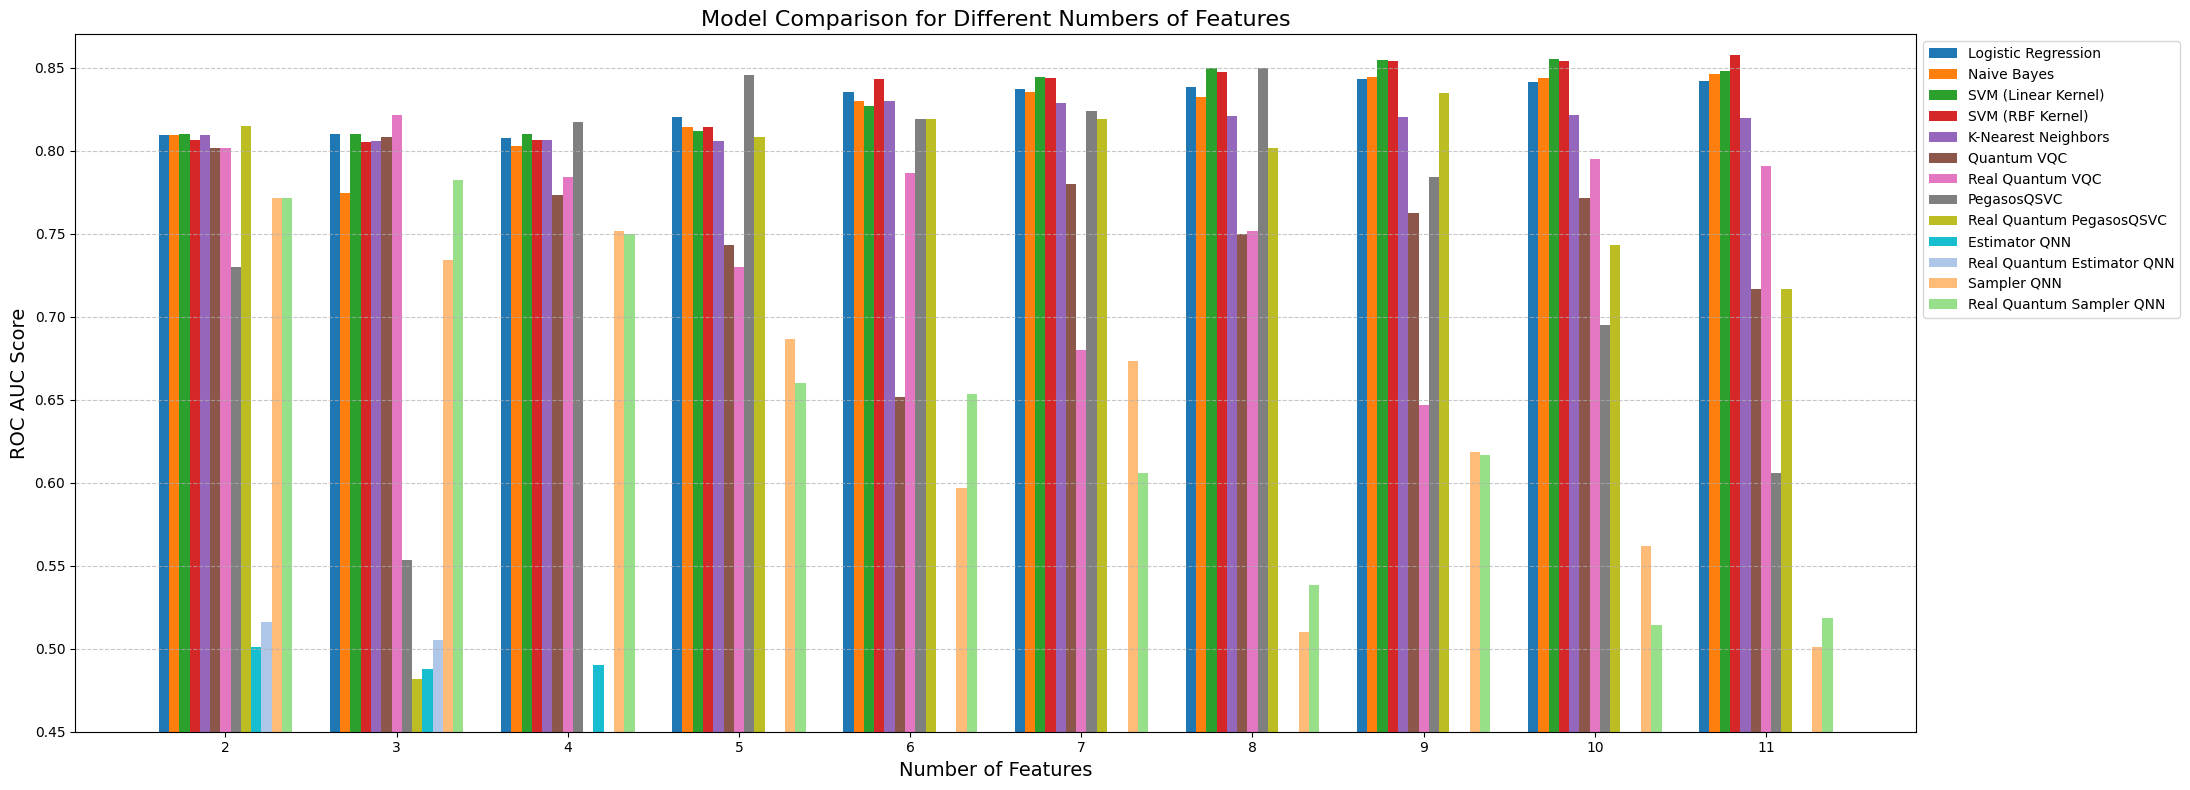

In [104]:


# Approach 2: Using tableau colors (very distinct)
tableau_colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5'
]

# Modified plotting code
plt.figure(figsize=(22, 8))
bar_width = 0.06
for i, model in enumerate(model_names):
    scores = [all_results[n][model] for n in feature_counts]
    x = np.arange(len(feature_counts))
    plt.bar(x + i * bar_width,
           scores,
           bar_width,
           label=model,
           color=tableau_colors[i]) 

plt.title("Model Comparison for Different Numbers of Features", fontsize=16)
plt.xlabel("Number of Features", fontsize=14)
plt.ylabel("ROC AUC Score", fontsize=14)
plt.ylim(0.45, 0.87)
plt.xticks(x + (len(model_names) - 1) * bar_width / 2, feature_counts)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()